# French Urban Entities

Author: Pascal `pascal@bayesimpact.org`

Date: 2017-12-19

In November 2017, the CREST asked us to analyze our users through the dimension of people living in urban vs rural areas. We started investigating and found a dataset from INSEE that they call [urban entities](https://www.insee.fr/fr/information/2115018). 

This notebook analyses this dataset. For each city in France it gives a mapping to the urban entity it is part of. According to the documentation, an urban entity is a contiguous urban area with less than 200m between buildings. Areas that are populated with less than 2000 inhabitants are considered as rural.

## Import

Here we use the `cleaned_data` lib that already does the import and basic cleaning on the data. To get the data required to run this notebook run:

```sh
docker-compose run --rm data-analysis-prepare make \
  data/geo/french_urban_entities.xls \
  data/geo/french_cities.csv \
  data/geo/insee_france_cities.tsv 
```

Let's open 3 datasets related to cities: the urban entities, the index of all French cities and the French city stats:

In [1]:
import os
from os import path

import pandas as pd

from bob_emploi.data_analysis.lib import cleaned_data

DATA_FOLDER = os.getenv('DATA_FOLDER')

urban_entities = cleaned_data.french_urban_entities(DATA_FOLDER)
urban_entities.head()

,UU2010,urban
CODGEO,,
01001,01000,0
01002,01000,0
01004,01302,3
01005,01000,0
01006,01000,0


In [2]:
cities = cleaned_data.french_cities(DATA_FOLDER)
cities.head()

,name,departement_id,region_id,current,current_city_id,arrondissement
city_id,,,,,,
01001,L'Abergement-Clémenciat,01,84,True,NaN,False
01002,L'Abergement-de-Varey,01,84,True,NaN,False
01003,Amareins,01,84,False,01165,False
01004,Ambérieu-en-Bugey,01,84,True,NaN,False
01005,Ambérieux-en-Dombes,01,84,True,NaN,False


In [3]:
city_stats = cleaned_data.french_city_stats(DATA_FOLDER)
city_stats.head()

,departement_id,zipCode,city_id,population,longitude,latitude
city_id,,,,,,
01284,01,01190,01284,618,4.91667,46.3833
01123,01,01290,01123,1058,4.83333,46.2333
01298,01,01130,01298,129,5.73333,46.1833
01422,01,01250,01422,1406,5.31667,46.1333
01309,01,01250,01309,88,5.43333,46.3333


Pretty nice: they are all indexed with the city ID, or "Code Officiel Géographique" so we can merge those three datasets. While doing that, let's make sure we restrict to current cities only:

In [4]:
all_cities = pd.merge(
    cities[cities.current & ~cities.arrondissement], city_stats,
    right_index=True, left_index=True, how='outer')
all_cities = pd.merge(
    all_cities, urban_entities,
    right_index=True, left_index=True, how='outer')
all_cities.head()

,name,departement_id_x,region_id,current,current_city_id,arrondissement,departement_id_y,zipCode,city_id,population,longitude,latitude,UU2010,urban
01001,L'Abergement-Clémenciat,01,84,True,NaN,False,01,01400,01001,784.0,4.91667,46.15,01000,0.0
01002,L'Abergement-de-Varey,01,84,True,NaN,False,01,01640,01002,221.0,5.41667,46.00,01000,0.0
01004,Ambérieu-en-Bugey,01,84,True,NaN,False,01,01500,01004,13835.0,5.35000,45.95,01302,3.0
01005,Ambérieux-en-Dombes,01,84,True,NaN,False,01,01330,01005,1616.0,4.90000,46.00,01000,0.0
01006,Ambléon,01,84,True,NaN,False,01,01300,01006,116.0,5.60000,45.75,01000,0.0


OK we're all set to start looking at the data.

## Coverage

In [5]:
official_cities = all_cities[all_cities.name.notnull()]
official_cities.urban.notnull().value_counts()

True    35416
Name: urban, dtype: int64

Pretty neat! We have urban data for all the cities. Now let's try to get a better understanding of this data.

## Data

The two fields we are going to dig are `urban` and `UU2010`. Supposedly `urban` gives a score where `0` means rural and then from `1` to `8`, it relates to bigger and bigger urban entities. `UU2010` gives the ID of the urban entity the city is part of.

Let's do some quick point checks:

In [6]:
official_cities.sort_values('population', ascending=False)[['name', 'urban', 'UU2010']].head()

,name,urban,UU2010
75056,Paris,8.0,00851
13055,Marseille,7.0,00759
69123,Lyon,7.0,00758
31555,Toulouse,7.0,31701
06088,Nice,7.0,06701


That sounds good: the biggest cities are inside the biggest urban entities.

Let's check one of them:

In [7]:
official_cities[official_cities.UU2010 == '00758']\
    .sort_values('population', ascending=False)[['name', 'urban', 'UU2010']].head()

,name,urban,UU2010
69123,Lyon,7.0,00758
69266,Villeurbanne,7.0,00758
69259,Vénissieux,7.0,00758
69290,Saint-Priest,7.0,00758
69256,Vaulx-en-Velin,7.0,00758


Cool, those are indeed cities that are part of the Lyon urban entities.

Let's check the other side of the spectrum:

In [8]:
official_cities[official_cities.urban == 0][['name', 'urban', 'UU2010', 'population']].head()

,name,urban,UU2010,population
01001,L'Abergement-Clémenciat,0.0,01000,784.0
01002,L'Abergement-de-Varey,0.0,01000,221.0
01005,Ambérieux-en-Dombes,0.0,01000,1616.0
01006,Ambléon,0.0,01000,116.0
01007,Ambronay,0.0,01000,2362.0


Indeed those seems like small villages (population count is low) however they seem to have an `UU2010` field which is common. Apparently that field is not valid for rural cities:

In [9]:
official_cities[official_cities.urban == 0]\
    .groupby(['UU2010', 'departement_id_x'])\
    .urban.count().to_frame().head()

,,urban
UU2010,departement_id_x,
01000,01,303
02000,02,725
03000,03,278
04000,04,177
05000,05,149


Alright, there seems to be a unique `UU2010` per département assigned to all rural cities in this département. We will make sure to ignore it.

Now let's see global stats for each level of urban entities:

In [10]:
def _stats_per_urban_group(cities):
    if cities.urban.iloc[0]:
        entities_population = cities.groupby('UU2010').population.sum()
    else:
        # Not grouping as UU2010 has no meaning for rural areas.
        entities_population = cities.population
    return pd.Series({
        'total_population': entities_population.sum().astype(int),
        'min_entity_population': entities_population.min().astype(int),
        'max_entity_population': entities_population.max().astype(int),
        'avg_entity_population': entities_population.mean().astype(int),
        'num_entities': len(entities_population),
    })
urban_stats = official_cities.groupby('urban').apply(_stats_per_urban_group)
urban_stats

,avg_entity_population,max_entity_population,min_entity_population,num_entities,total_population
urban,,,,,
0.0,494,8047,0,28182,13942186
1.0,3319,5205,600,1181,3919775
2.0,6563,10324,1298,590,3872309
3.0,13134,19726,1281,244,3204727
4.0,29622,50026,6784,147,4354513
5.0,68068,93915,40820,68,4628651
6.0,145689,199852,86655,30,4370672
7.0,495323,1559789,207658,31,15355038
8.0,10460118,10460118,10460118,1,10460118


OK, many things interesting in those stats. First the size of entities seems to be globally consistent with the documentation: entities level are defined by their sizes. For the small numbers though, there seem to be some slight inconsistencies but we'll say that population data is not very precise.

Let's check the distribution of the number of entities by level:

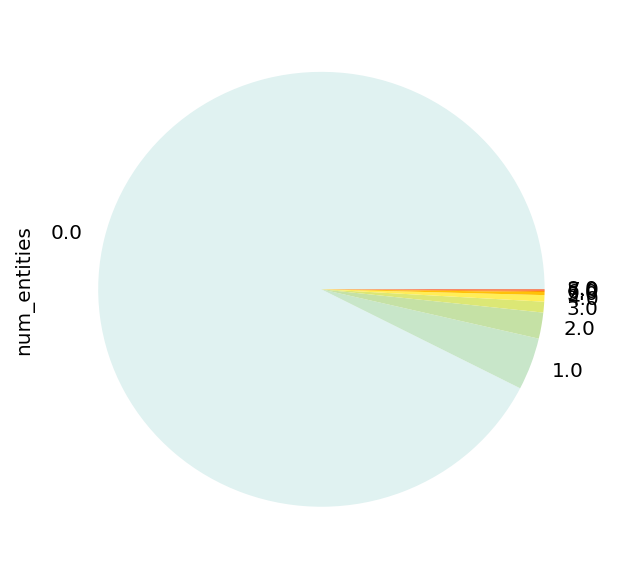

In [11]:
COLOR_MAP = [
    '#e0f2f1',
    '#c8e6c9',
    '#c5e1a5',
    '#dce775',
    '#ffee58',
    '#ffc107',
    '#ff9800',
    '#ff5722',
    '#795548',
]
urban_stats.num_entities.plot(kind='pie', figsize=(5, 5), colors=COLOR_MAP);

The huge majority of cities are rural, and only very few of them are part of the largest urban entities.

Let's look at it from another angle, and check the population distribution:

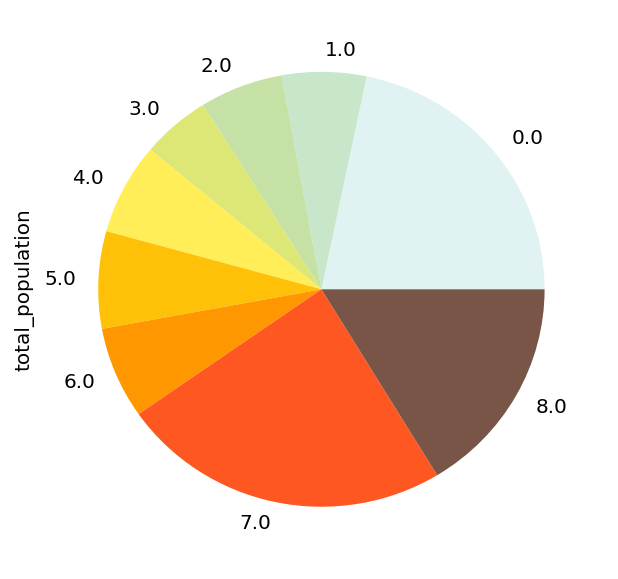

In [12]:
urban_stats.total_population.plot(kind='pie', figsize=(5, 5), colors=COLOR_MAP);

OK, this is a whole other picture: rural areas account only for less than a quarter of the population, and actually half of the population lives in urban entities level 6 or above (each entity is larger than 100k inhabitants).

Finally let's plot the urban entities for France metropolitan area:

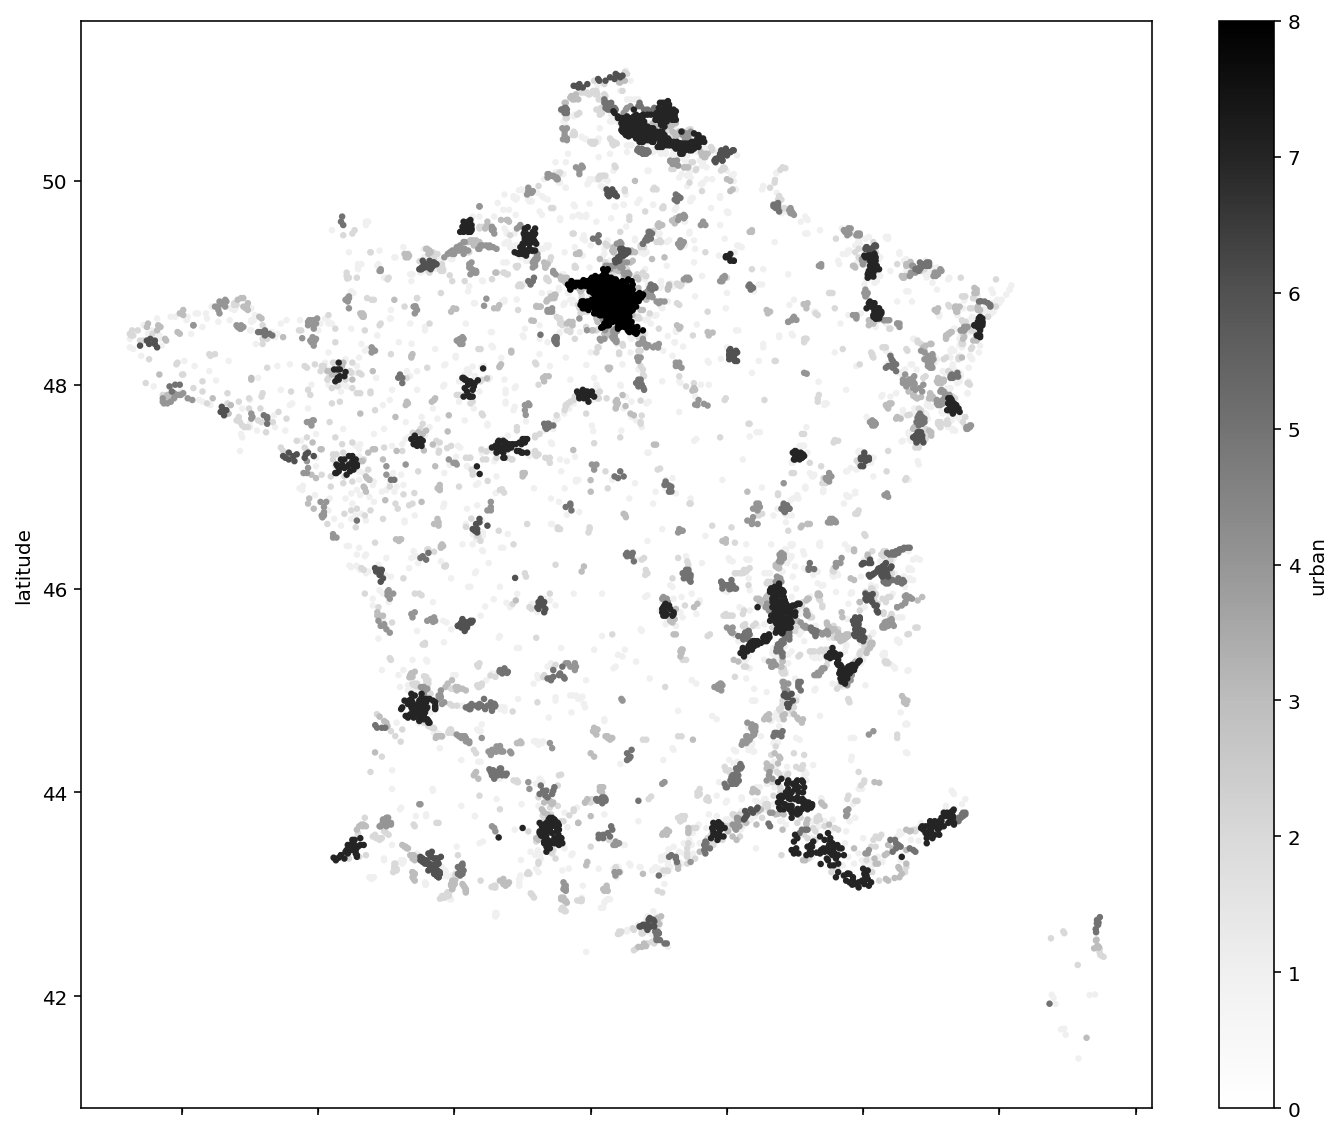

In [13]:
is_in_metropol = (official_cities.longitude > -5) & (official_cities.latitude > 25)
official_cities[is_in_metropol & official_cities.urban.notnull()]\
    .sort_values('urban')\
    .plot(kind='scatter', x='longitude', y='latitude', s=5, c='urban', figsize=(12, 10));

Nice! The largest urban entities seem to be located where we know are the largest cities with the benefit of knowing how far it extends.

# Conclusion

The urban entities dataset is quite clean. The major learning is that although more than 80% of cities are rural, less than 25% of the population is in a rural area. The slicing by urban level (from 1 to 8) can also be used to distinguish people living in small or large urban areas even though their own city might just be a small city next to a big one.